# Importy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import colors
from fractions import Fraction
import random
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, VBox, HBox
from IPython.display import display, clear_output

In [4]:
def lam_1(x):
    return 0.8 + 0.8*np.sin(x/2)

def lam_2(x):
    return (np.exp(2 * np.sin(x/12 + 3) - 0.9))**3

def _lam_3(x):
    return 1/2

lam_3 = np.vectorize(_lam_3)

def lam_4(x):
    return 0.7 + 0.6 * np.sin(x/7 + 2)**2*np.cos(x/3 + 1)

def lam_5(x):
    return 0.2 + 0.2 * np.sign(np.sin(x/24 + 6))

def lam_6(x):
    return 0.1 + 0.1 * np.sin(np.sqrt(x))

def lam_7(x):
    return 0.3 + 0.3 * np.sin(4*np.sin(x/2))

In [5]:
def tabinv(dic_X):
    """Returns key from dic_X. dic_X = { x : p, ...}, where p is the probability of x."""
    xi = [str(i) for i in dic_X.keys()]
    pi = list(dic_X.values())
    pi_frac = [Fraction.from_float(i).limit_denominator(1000) for i in pi]

    q = np.lcm.reduce([i.denominator for i in pi_frac])
    ai = [i.numerator * q/i.denominator for i in pi_frac]
    Q = np.zeros(q, dtype=object)
    count = 0
    
    for i in range(len(xi)):
        Q[count:count + int(ai[i])] = xi[i]
        count += int(ai[i])
    
    val = random.randint(0, q-1)
    return eval(Q[val])

Poniżej znjaduje się nasza interpretacja zadania z symulowaniem ruchu samochodowego. Postanowiłyśmy wykorzystać tutaj możliwości Pythona i zdecydowałyśmy się na obiektową implementację naszego ruchu. 


# Klasa Car

Klasa Car zawiera podstawowe informacje o poruszających się samochodach. Postanowiłyśmy pozostawić rozróżnienie samochodów na miejsce z którego pochodzą, co na animacjach można zobaczyć jako różne kolory. 

In [6]:
class Car:
    """Class of cars in the city"""
    def __init__(self, n, t):
        """Arguments:
            n - colour/intensity (1, 2, ... 7)
            t - time of occurance
        Initialize:
            self.n - coulour as n
            self.start - time of occurance as t
            self.on_road - is the car on road as true
            self.next_dir - next direction of the car as None
            self.moves - next moves for car as an empty list
            self.on_iter - is the car on intersection as None
        The function also calls the setup function."""

        self.n = n 
        self.start = t
        self.setup(n)
        self.on_road = True
        self.next_dir = None
        self.next_moves = []
        self.on_inter = None

    def __str__(self):
        """Ovveride of print method for dthe class. Print x, y, direction and
         next direction of the car"""
        return f"n:{self.n}, x:{self.x}, y:{self.y}, dir:{self.dir}, next_dir: {self.next_dir}"

    def setup(self, n):
        """Set direction of the car based od colour of the car.
        The directions are: (x,y) (0,-1)-up, (1,0)-right, (0,1)-down, (-1,0)-left
            Arguments:
                n - colour/intensity of the car"""
        dic = {0:[(0,-1), 28, 11], 1:[(0,-1) ,28, 27], 2:[(-1,0), 9, 41], 3:[(1,0), 10, 0], 4:[(0,1), 0, 10], 5:[(0,1),0,26], 6:[(0,1),0,35]}
        self.dir, self.y, self.x = dic[n]

    def is_on_road(self):
        """Return:
            value self.on_road."""
        return self.on_road

    def will_be_on_road(self, a=42, b=29): 
        """Take optional arguments:
                a - length of map
                b = width of map
            Return:
                True - if in next move car would be on road
                False - otherwise"""
        # a - x, b - y
        x = self.x + self.dir[0]
        y = self.y + self.dir[1]
        if x < 0 or y < 0 or y > b - 1  or x > a - 1:
            return False
        return True

# Klasa Intersection

Klasa ta zwiera informacje na temat skrzyżowań. Na mapie jest ich 4, tak więc każde z nich przechowuje informacje na temat dotyczących go świateł. Wprowadziłyśmy również odrębny licznik czasu na skrzyżowaniu - zapętla się on i można go obliczyć używając do tego parametrów świateł oraz czasu głównego. W tej sposób odnajdujemy się w czasie na skrzyżowaniu i możemy stwierdzić, czy interesujące nas światło jest obecnie zielone.

In [7]:
class Intersection():
    """Class of intersections"""
    def __init__(self, i):
        """Arguments:
            i - number of intersection (1, 2, 3, 4)
        Initialize:
            self.inter_name - name of intersection as i
            self.lights - dictionary of lights on the intersection as empty dictionary
            self.count - count for order of lights as 0
            self.engaged - is there any cars on the intersection as False
            self.green_red_times - list of times when lights change set to [0]
                [0, tau1, tau1 + sigma1, tau1 + sigma1 + tau2, ...]"""
        self.inter_name = i
        self.lights = {}
        self.count = 0
        self.engaged = False
        self.green_red_times = [0]
    
    def add_lights(self, l_name, tau, pi, sigma):
        """This function sets lights in lights dictionary and
         add times to green_red_times list.
        Arguments:
            l_name - name of the lights e.g "t1"
            tau - time of green light for the light
            pi - dictionary of directions, where the key is a direction tuple and
                value is probability e.g. {(0, 1):1/2}
            sigma - time between the end of the green light and begining of green
                light for another street"""

        self.lights[l_name] = [tau, pi, sigma, self.count]
        self.count += 1
        self.green_red_times.append(self.green_red_times[-1] + tau)
        self.green_red_times.append(self.green_red_times[-1] + sigma)
    
    def change_lights(self, l_name, tau, pi , sigma):
        """Change lights of l_name for lights with another tau, pi and sigma.
        Arguemnts:
            l_name - name of the lights
            tau - time of green light for the light
            pi - dictionary of directions, where the key is a direction tuple and
                value is probability e.g. {(0, 1):1/2}
            sigma - time between the end of the green light and begining of green
                light for another street"""
        count = self.lights[l_name][3]
        self.lights[l_name] = [tau, pi, sigma, count]
        temp = self.green_red_times[0: 2*count + 1]
        temp.append(temp[-1] + tau)
        temp.append(temp[-1] + sigma)
        for i in range(count, self.count):
            temp.append(temp[-1] + self.green_red_times[i + 1] -  self.green_red_times[i])
            temp.append(temp[-1] + self.green_red_times[i + 2] -  self.green_red_times[i + 1])

    def intersection_time(self, t):
        """Arguments:
            t - current time
        Return:
            time that passed since the begining of current loop of time
            in the intersection"""
        self.loop_time = [i[0] + i[2] for i in self.lights.values()]
        return t%sum(self.loop_time)  #(tau1 + sigma1 + tau2+ sigma2)  

    def is_green(self, l_name, t):
        """Arguments:
            l_name - name of the lights
            t - current time
        Return:
            1 - if the light is green
            0 - if the light is red"""
        for i in range(len(self.green_red_times)-1):
            if self.green_red_times[i] <= self.intersection_time(t) < self.green_red_times[i + 1]:
                if i % 2 == 0 and self.lights[l_name][-1] == i/2:
                    return 1
                return 0

    def get_dir(self, l_name):
        """Using table method of generating pseudorandom values from distribution
        generate next_direction.
        Arguments:
            l_name - name of the lights
        Return:
            next direction"""
        dic = self.lights[l_name][1]
        return tabinv(dic)


# Klasa MotorTraffic

Jest to główna klasa pozwalająca na symulowanie ruchu samochodowego. Łączy ona klasy Car oraz Interection. Zawierają się w niej funkcje umożliwiające poruszanie samochodami, generowanie oraz dodawanie nowych samochodów, ale również np. zmienianie parametrów świateł. Jako podstawę naszej symulacji wybrałyśmy macierz 42x29 jako naturalną reprezentację planszy. Wolne miejsca na ulicy mają wartość 0, obszary wyłączone z ruchu -1, natomiast samochody przyjmują wartości dodanie od 1 do 7. Ruch samochodowy podlega następującym zasadom:
* Samochody pojawiają się na ulicach wyjazdowych zgodnie z niejednorodnym procesem Poissona z funkcjami intensywności $\lambda_1, \ldots \lambda_7$.
* Ruch samochodowy jest prawostronny.
* Samochody poruszają się o jedną kratkę na jednostkę czasu, o ile kratka przed nimi jest wolna lub nie dotrą na skrzyżowanie.
* Każde ze skrzyżowań posiada własne światła.
* Każde ze świateł jest zielone przez określoną, szczególną dla tego światła chwilę $\tau$, po czym światło zmienia się na czerwone. Zanim zapali się światło zielone dla następnego kierunku mija chwila $
\sigma$. Wartość parametru $\sigma$ powinna wynosić przynajmniej 4, aby zapobiegać kolizjom.
* Na każdym ze skrzyżowań światło zielone jest tylko dla jednego kierunku na raz. 
* Światła zielone zapalają się na kolejnych światłach zgodnie z kierunkiem ruchu wskazówek zegara.
* Po przyjechaniu przed skrzyżowanie każdy samochód losuje kierunek (z rozkładu $\pi$).
* Po wyjechaniu samochodu poza mapę nie bierzemy go pod uwagę w naszej symulacji.
* Samochód na skrzyżowaniu dalej porusza się z prędkością jedna kratka na sekundę.
* Tylko jeden samochód może znajdować się na skrzyżowaniu.


In [8]:
class MotorTraffic:
    """General class for the simulation"""
    def __init__(self, lambdas=None):
        """Arguments:
            lambdas - list of seven functions  - intesities for the poisson process (optional)
        Initialize:
            self.t - the clock as 0
            self.cars_on_road - list of cars on road as an empty list
            self.waiting cars - dictionary where keys are streets numbers and 
                values are empty lists
            self.map - value of function prepare_map
            self.lambdas - as list of lambdas (lam_1, ...) if lambdas argument
                is none, if they are different - as lambdas argument
            self.appear_times - list of times from poisson process for every lambda
            self.pos_to_light  - dictionary where positions are keys and names of 
                lights are values
            self.light_to_S - dictionary where names of lights are keys and 
                number of intersections are values.
            self.intersection_list - list of intersections as a list of objects
                from intersection class
            self.waiting_times_lights - as dictionary where keys are lights names
                and values are lists [0, 0]
        """
        self.t = 0  # clock
        self.cars_on_road = []
        self.waiting_cars = {n:[] for n in range(7)}
        self.map = self.prepare_map()
        if not lambdas:
            self.lambdas = [lam_1, lam_2, lam_3, lam_4, lam_5, lam_6, lam_7]
        else:
            self.lambdas = lambdas
        self.appear_times = [self.no_homo_poisson(lam) for lam in self.lambdas]
        self.pos_to_light = {(23, 11):"t1", (21, 10):"t2", (11, 11):"t3", (10, 9):"t4", (8, 10):"t5",\
                            (9, 12):"t6", (11, 27):"t7", (10, 25):"t8", (8, 26):"t9", (9, 28):"t10", \
                            (10, 34):"t11", (8, 35):"t12", (9, 37):"t13"}
        self.light_to_S = {"t1":1, "t2":1, "t3":2, "t4":2, "t5":2, "t6":2, "t7":3, "t8":3, "t9":3,\
                           "t10":3, "t11":4, "t12":4, "t13":4}
        self.intersection_list = [Intersection(i) for i in range(1,5)]
        # (x,y) (0,-1) - up, (1,0) - right, (0,1) - down, (-1,0) - left
        self.init_lights()
        self.waiting_times_lights = {"t1":[0, 0], "t2":[0, 0], "t3":[0, 0], "t4":[0, 0], "t5":[0, 0], "t6":[0, 0], "t7":[0, 0], "t8":[0, 0], "t9":[0, 0],\
                           "t10":[0, 0], "t11":[0, 0], "t12":[0, 0], "t13":[0, 0]}  # [sum of waiting times on light, number of cars]


    def init_lights(self):
        """Inital function to add lights to the intersections"""
        self.intersection_list[0].add_lights("t1", 5, {(0, -1):1/3, (-1, 0):1/3, (0, 1):1/3}, 4)
        self.intersection_list[0].add_lights("t2", 5, {(0, 1):1/3, (-1, 0):1/3, (0, -1):1/3}, 4)
        self.intersection_list[1].add_lights("t3", 5, {(0, -1):1/4, (0, 1):1/4, (-1, 0):1/4, (1, 0):1/4}, 4)
        self.intersection_list[1].add_lights("t4", 5, {(0, -1):1/4, (0, 1):1/4, (-1, 0):1/4, (1, 0):1/4}, 4)
        self.intersection_list[1].add_lights("t5", 5, {(0, -1):1/4, (0, 1):1/4, (-1, 0):1/4, (1, 0):1/4}, 4)
        self.intersection_list[1].add_lights("t6", 5, {(0, -1):1/4, (0, 1):1/4, (-1, 0):1/4, (1, 0):1/4}, 4)
        self.intersection_list[2].add_lights("t7", 5, {(0, -1):1/4, (0, 1):1/4, (-1, 0):1/4, (1, 0):1/4}, 4)
        self.intersection_list[2].add_lights("t8", 5, {(0, -1):1/4, (0, 1):1/4, (-1, 0):1/4, (1, 0):1/4}, 4)
        self.intersection_list[2].add_lights("t9", 5, {(0, -1):1/4, (0, 1):1/4, (-1, 0):1/4, (1, 0):1/4}, 4)
        self.intersection_list[2].add_lights("t10", 5, {(0, -1):1/4, (0, 1):1/4, (-1, 0):1/4, (1, 0):1/4}, 4)
        self.intersection_list[3].add_lights("t11", 5, {(0, -1):1/3, (-1, 0):1/3, (1, 0):1/3}, 4)
        self.intersection_list[3].add_lights("t12", 5, {(0, -1):1/3, (-1, 0):1/3, (1, 0):1/3}, 4)
        self.intersection_list[3].add_lights("t13", 5, {(0, -1):1/3, (-1, 0):1/3, (1, 0):1/3}, 4)


    def change_lights(self, l_name, tau, pi, sigma):
        """Change certain lights values.
        Arguments:
            l_name - name of the lights e.g "t1"
            tau - time of green light for the light
            pi - dictionary of directions, where the key is a direction tuple and
                value is probability e.g. {(0, 1):1/2}
            sigma - time between the end of the green light and begining of green
                light for another street"""
        index = self.light_to_S[l_name] - 1
        self.intersection_list[index].change_lights(l_name, tau, pi, sigma)


    def change_tau(self, l_name, tau):
        """Change tau value of the lights.
        Arguments:
            l_name - name of the lights
            tau - green time lights"""
        index = self.light_to_S[l_name] - 1
        temp = self.intersection_list[index].lights[l_name]
        temp[0] = tau
        self.change_lights(l_name, *temp[0:3])


    def prepare_map(self):
        """Prepare matrix of zeros where the streets are and -1 where there is not
        Return:
            map - the matrix"""
        map = -np.ones((29, 42))
        map[:, 10:12] = np.zeros((29, 2))  # l_5 / l_1
        map[:, 26:28] = np.zeros((29, 2))  # l_6/l_2
        map[0:11, 35:37] = np.zeros((11, 2))  # l_7
        map[9:11, :] = np.zeros((2, 42))  # l_4/ l_3
        map[22, 0:12] = np.zeros((1, 12)) # one-way
        return map


    def no_homo_poisson(self, l_fun, T=200, n=1000):
        """Returns next IPP jump"""
        t = self.t
        k = np.linspace(0, T, n)
        M = max(l_fun(k))
        while True:
            U1 = np.random.random()
            t  -= (1/M)*np.log(U1)
            U2 = np.random.random()
            if U2 <= l_fun(t)/M:
               return t


    def new_car_n(self, n):
        """If the time of car's appearance is now, adds new instance of Car class to the waiting_list.
         If it is possible also on the map and to the cars_on_map.
         Arguments:
            n - colour/intensity (1, 2, ... 7) of car
        """
        if self.appear_times[n] <= self.t:
            self.appear_times[n] = self.no_homo_poisson(self.lambdas[n])
            car = Car(n, self.t)
            self.waiting_cars[n].append(car)
            waiting_list = self.waiting_cars[n]
            if self.map[waiting_list[0].y, waiting_list[0].x] == 0:  # there's no car
                add_car = waiting_list.pop(0)
                self.cars_on_road.append(add_car)
                add_car.x -= add_car.dir[0]
                add_car.y -= add_car.dir[1]


    def add_waiting_car(self, n):
        """If possible adds car from waiting_cars to the street. 
        Argument n defines where is that car from (which entrance).
        """
        waiting_list = self.waiting_cars[n]
        if len(waiting_list) > 0 and self.map[waiting_list[0].y, waiting_list[0].x] == 0:
            add_car = waiting_list.pop(0)
            self.cars_on_road.append(add_car)
            add_car.x -= add_car.dir[0]
            add_car.y -= add_car.dir[1]


    def move_on_map(self, car, next_pos):
        """Change the current position in the matrix to 0 and the next position
        to the specific colour"""
        if (0 <= car.y < 29 and 0 <= car.x < 42):
            self.map[car.y , car.x] = 0
        self.map[next_pos[1], next_pos[0]] = car.n + 1


    def move_car(self, car):
        """If possible moves the given car on map. Diffrent actions if car will
         no longer be on the map, or if it will be on intersection, or already 
         is turning.
         Arguments:
            car - the car we want to move (instance of Car class)
        """
        lights = self.is_on_intersection(car)
        if lights: 
            self.waiting_times_lights[lights][0] += 1

            S_num = self.light_to_S[lights]
            inter = self.intersection_list[S_num - 1]  # class Intersection
            if inter.is_green(lights, self.t):
                car.next_dir = inter.get_dir(lights)
                self.next_pos(car, lights)
                if self.map[car.next_moves[-1][1], car.next_moves[-1][0]] == 0 and not inter.engaged:
                    self.waiting_times_lights[lights][1] += 1
                    next_pos = car.next_moves.pop(0)
                    self.move_on_map(car, next_pos)
                    car.x = next_pos[0]
                    car.y = next_pos[1]
                    car.dir = car.next_dir
                    inter.engaged = True
                    car.on_inter = inter

        elif car.next_moves:
            next_pos = car.next_moves.pop(0)
            self.move_on_map(car, next_pos)
            car.x = next_pos[0]
            car.y = next_pos[1]
            if not car.next_moves:
                car.on_inter.engaged = False

        else:
            if not car.will_be_on_road():
                self.map[car.y, car.x] = 0
                car.on_road = False
                return 0
            elif self.map[car.y + car.dir[1], car.x + car.dir[0]] == 0:
                next_pos = (car.x + car.dir[0], car.y + car.dir[1])
                self.move_on_map(car, next_pos)
                car.x = next_pos[0]
                car.y = next_pos[1]


    def next_pos(self, car, lights):
        """Computes next positions of car on the intersection, assings them to car.next_moves.
        Arguments:
            car - the vehicle which is turning (instance of class Car)
            lights - name of light, where is car (str)
        """
        if lights == "t1" and car.next_dir == (-1, 0):
            car.next_moves = [(car.x, car.y + car.dir[1]), (car.x + car.next_dir[0], car.y + car.dir[1]), (car.x + 2*car.next_dir[0], car.y + car.dir[1])]
        elif (lights == "t1" or lights == "t2") and car.next_dir == car.dir:
            next_pos = (car.x + 2*car.dir[0], car.y + 2*car.dir[1])
            car.next_moves = [(car.x + car.dir[0], car.y + car.dir[1]), (car.x + 2*car.dir[0], car.y + 2*car.dir[1])]
        else:
            if car.dir == car.next_dir:  # go straight
                car.next_moves = [(car.x + i*car.dir[0], car.y + i*car.dir[1]) for i in range(1,4)]
            elif car.dir == (-car.next_dir[0], -car.next_dir[1]):  # turn back
                if car.dir[0] == 0:  # car is moving up or down 
                    car.next_moves = [(car.x, car.y + car.dir[1]), (car.x + car.dir[1], car.y + car.dir[1]), (car.x + car.dir[1], car.y)]
                elif car.dir[1] == 0:  # car is moving right or left
                    car.next_moves = [(car.x + car.dir[0], car.y), (car.x + car.dir[0], car.y - car.dir[0]), (car.x, car.y - car.dir[0])]           
            elif np.linalg.det([car.dir, car.next_dir]) == 1:  # turn right
                car.next_moves = [(car.x + car.dir[0], car.y + car.dir[1]), (car.x + car.dir[0] + car.next_dir[0], car.y + car.dir[1] + car.next_dir[1])]
            elif np.linalg.det([car.dir, car.next_dir]) == -1:  # turn left
                car.next_moves = [(car.x + car.dir[0], car.y + car.dir[1]), (car.x + 2*car.dir[0], car.y + 2*car.dir[1]),(car.x + 2*car.dir[0] + car.next_dir[0], car.y + 2*car.dir[1] + car.next_dir[1]) ,(car.x + 2*car.dir[0] + 2*car.next_dir[0], car.y + 2*car.dir[1] + 2*car.next_dir[1])]


    def is_on_intersection(self, car):
        """Arguments:
            car - object of Car class
        Return:
            name of the light - if the car is before the intersection
            False - if the car is not"""
        pos = (car.y, car.x)
        if pos in self.pos_to_light:
            return self.pos_to_light[pos]
        return False

        
    def step(self):
        """Step for every second of the simulation"""
        for n in range(7):
            self.new_car_n(n)
        for n in range(7):
            self.add_waiting_car(n)
        for car in self.cars_on_road:
            self.move_car(car)
        self.cars_on_road = list(filter(lambda car: car.is_on_road(), self.cars_on_road))
        self.t += 1       

# Analizy

Będziemy analizować ilość samochodów na całej mapie, jak i na poszczególnych ulicach. Przeanalizujemy działanie świateł, skupimy się na czasach oczekiwania na wjazd na skrzyżowanie oraz ile samochodów przez nie przejeżdza. Przyjżymy się również ilości samochodów, które czakają na wjazd do naszego miasta.

## Pierwszy zestaw parametrów

Pierwszy zestaw parametrów to przede wszystkim domyślne intensywności $\lambda_1, \dots, \lambda_7$. Na każdym świetle $t_j$ światło zielone pali się przez $\tau_j = 5$ jednostek czasu, z kolei $\sigma_j = 4$. Prawdopodobieństwo skrętu w każdą ulice jest takie samo na całym skrzyżowaniu.

**Średnia ilość samochodów na mapie od czasu**

In [ ]:
def mean_number_of_all_cars(N=100, T=1000, lambdas=None, tau_list=[5 for i in range(13)]):
    """Calculates mean number of cars on a map. Takes mean of N MottorTraffic objects.
    Returns list of means from begining to time T. If lambdas is gives, it changes the default 
    intensities of car's appearance to the gives (lambdas - list of 7 functions). 
    Similarly, tau_list (list of 13 ints) enables to change the durations of green lights.
    """
    M = [MotorTraffic(lambdas=lambdas) for n in range(N)]
    if tau_list != [5 for i in range(13)]:
        for count, i in enumerate(tau_list):
            if i != 5:
                M.change_tau("t" + str(count + 1), i)
    count_cars = np.zeros(T)
    for t in range(T):
        for m in M:
            m.step()
            count_cars[t] += len(m.cars_on_road)
    return count_cars/N

In [ ]:
number_of_cars = mean_number_of_all_cars()

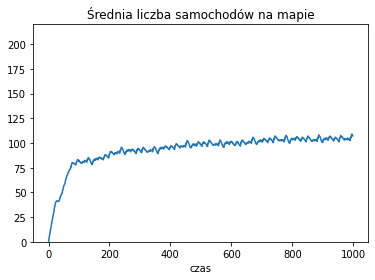

In [ ]:
plt.plot(number_of_cars)
plt.title("Średnia liczba samochodów na mapie")
plt.xlabel('czas')
plt.ylim(0, 220)
plt.show()

Ta analiza ma pokazać generalne zapełnienie ulic samochodami. Całkowita pojemność naszego wycinka miasta wynosi 220 samochodów. Możemy zobaczyć, że chociaż (jak okaże się później) samochody bardzo długo czekają na wjazd do naszego miasta ilość samochodów stabilizuje się na stosunkowo niewielkiej ilości.

**Ilość aut na każdej ulicy od czasu**


Będziemy badać ilość aut na 11 ulicach, bo tyle jest $n$ na rysunku.

In [ ]:
def cars_on_street(T=1000, lambdas=None, tau_list=[5 for i in range(13)]):
    """Calculates number of cars on each street in time from 0 to T. 
    If lambdas is gives, it changes the default intensities of car's appearance 
    to the gives (lambdas - list of 7 functions). Similarly, tau_list (list of 13 ints)
    enables to change the durations of green lights."""
    M = MotorTraffic(lambdas=lambdas)
    if tau_list != [5 for i in range(13)]:
        for count, i in enumerate(tau_list):
            if i != 5:
                M.change_tau("t" + str(count + 1), i)
    cars_streets = np.zeros((11, T))
    for t in range(T):
        M.step()
        a = M.map[9:11, 0:10] #n4
        cars_streets[3, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[22, 0:10] #n2
        cars_streets[1, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[0:9, 10:12] #n5
        cars_streets[4, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[0:9, 26:28] #n7
        cars_streets[6, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[0:9, 35:37] #n10
        cars_streets[9, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[9:11, 12:26] #n6
        cars_streets[5, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[9:11, 28:35] #n9
        cars_streets[8, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[9:11, 37:42] #n11
        cars_streets[10, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[11:22, 10:12] #n3
        cars_streets[2, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[23:29, 10:12] #n1
        cars_streets[0, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[11:29, 26:28] #n8
        cars_streets[7, t] = np.sum(np.where(a > 0, 1, 0))
    return cars_streets

def mean_cars_on_street(T=1000, N=100, lambdas=None, tau_list=[5 for i in range(13)]):
    """Calculates mean number of cars on each street in time from 0 to T. Takes mean 
    of N MottosTraffics objects.If lambdas is gives, it changes the default
    intensities of car's appearance to the gives (lambdas - list of 7 functions). 
    Similarly, tau_list (list of 13 ints) enables to change the durations of green lights."""
    values = np.zeros((11, T))
    for n in range(N):
        values += cars_on_street(T, lambdas=lambdas,  tau_list=tau_list)
    return values/N

Nieuśredniona ilość aut na poszczególnych ulicach wygląda następująco:

In [ ]:
cars_streets = cars_on_street()

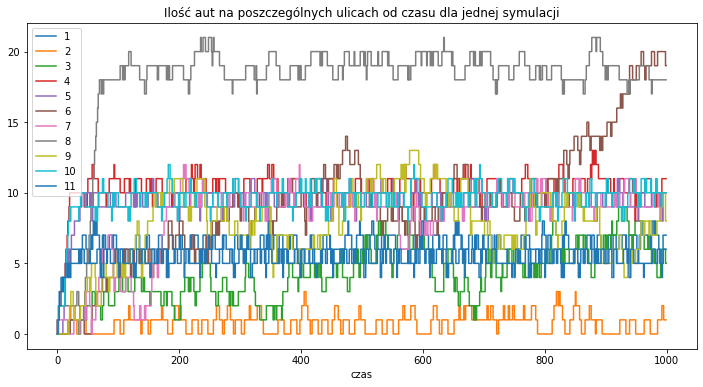

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(11):
    plt.step(range(1000), cars_streets[i, :])
plt.title("Ilość aut na poszczególnych ulicach od czasu dla jednej symulacji")
plt.xlabel("czas")
plt.legend(range(1,12))

Z kolei uśredniodnia ilość ($N=100$) aut na poszczególnych uliach:

In [ ]:
mean_cars_streets = mean_cars_on_street()

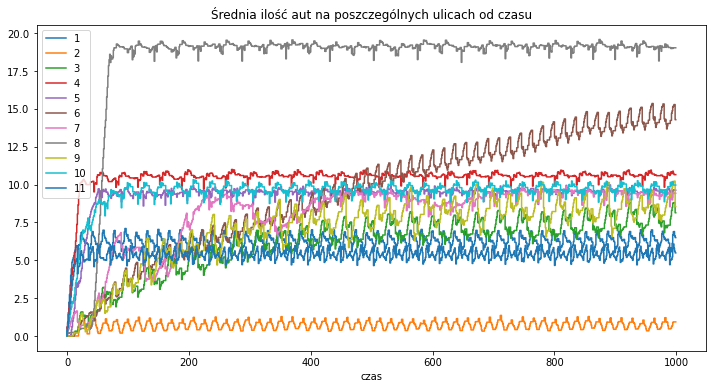

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(11):
    plt.step(range(1000), mean_cars_streets[i, :])
plt.title("Średnia ilość aut na poszczególnych ulicach od czasu")
plt.xlabel("czas")
plt.legend(range(1,12))

Możemy zauważyć, że po pewnym czasie ilość aut na większości ulic stabilizuje się i widzimy tylko niewielkie fluktuacje. Na uśrednionym wykresie można zauważyć pewną okresowość tych fluktuacjii, co najpewniej związane jest z cyklicznymi zmianami koloru świateł.

Najwięcej samochodów znajduje się na ulicy $n_8$, która jest najdłuższa ze wszystkich, a najminiej na ulicy jednokierunkowej - co w obu przypadkach było do przewidzenia.

Spójrzmy jeszcze na procentowe zapełnienie każdej z tych ulic.

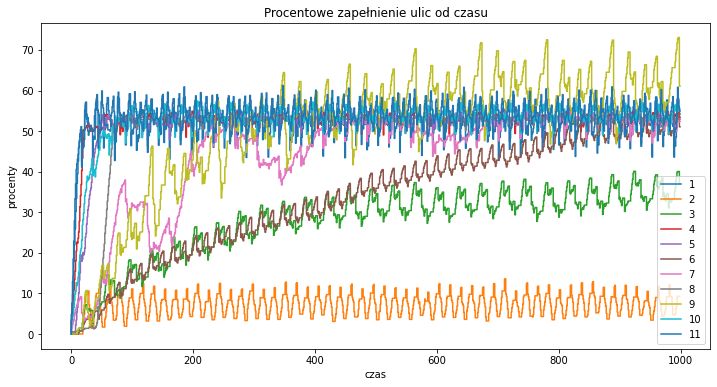

In [ ]:
streets_capacity = [12, 10, 22, 20, 18, 28, 18, 18*2, 14, 18, 10]
plt.figure(figsize=(12, 6))
for i in range(11):
    plt.step(range(1000), mean_cars_streets[i, :]/streets_capacity[i]*100)
plt.title("Procentowe zapełnienie ulic od czasu")
plt.ylabel("procenty")
plt.xlabel("czas")
plt.legend(range(1,12))

Zauważmy, że ulice które praktycznie od razu zapełniają się na poziomie ok. $50 \%$, to ulice wjazdowe: $n_1, n_4, n_5, n_8, n_{10}$ i $n_{11}$. Takie zapełnienie oznacza, że jeden pas jest cały czas zejęty, oczywiście będzie to pas wjazdowy do miasta. Po nieco dłuższym czasie korkuje się też ulica $n_6$ i wtedy każdy kto chce wjechać do naszego miasta musi stać w korku. Najbardziej zapełnioną ulicą jest ta pomiędzy skrzyżowaniem $S_3$ i $S_4$.

**Średni czas oczkiwania na poszczególnych światłach**

Obliczmy średni czas jaki samochód spędza na czakaniu na poszczególnych światłach.

In [ ]:
def mean_wait_on_lights(N=100,T=1000, lambdas=None, tau_list=[5 for i in range(13)]):
    """Calculates mean waiting times on each light during T steps. Takes mean 
    of N MottosTraffics objects. If lambdas is gives, it changes the default
    intensities of car's appearance to the gives (lambdas - list of 7 functions). 
    Similarly, tau_list (list of 13 ints) enables to change the durations of green lights."""
    waiting_times = np.zeros((N, 13))
    M = [MotorTraffic(lambdas=lambdas) for n in range(N)]
    if tau_list != [5 for i in range(13)]:
        for count, i in enumerate(tau_list):
            if i != 5:
                for item in M:
                    item.change_tau("t" + str(count + 1), i)
    for t in range(T):
        for m in M:
            m.step()
    for i, m in enumerate(M):
        waiting_times[i,:] = [m.waiting_times_lights[light][0]/m.waiting_times_lights[light][1] if m.waiting_times_lights[light][1] != 0 else 0 for light in m.waiting_times_lights]
    return np.sum(waiting_times, axis=0)/N

In [ ]:
wait_on_lights = mean_wait_on_lights()

Text(0.5, 0, 'nr światła')

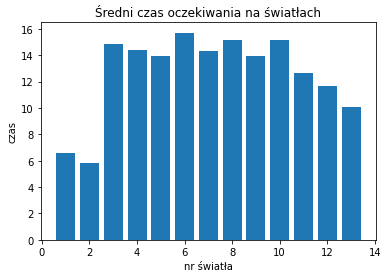

In [ ]:
plt.bar(range(1, 14), wait_on_lights)
plt.title("Średni czas oczekiwania na światłach")
plt.ylabel("czas")
plt.xlabel("nr światła")

Powyższy wykres przedstawia średni czas czekania na każdym świetle dla 100 symulacjii trwających 1000 jednostek czasu. Widać wyraźnie dłuższy czas oczekiwania na światłach $t_3, \dots, t_{10}$. Sumując odpowienio te czasy możemy obliczyć średni czas oczekiwania na poszczególnych skrzyżowaniach.

Text(0.5, 0, 'nr skrzyżowanie')

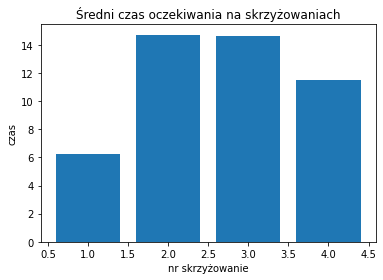

In [ ]:
plt.bar(range(1, 5), [sum(wait_on_lights[0:2])/2, sum(wait_on_lights[2:6])/4, sum(wait_on_lights[6:10])/4, sum(wait_on_lights[10:])/3])
plt.title("Średni czas oczekiwania na skrzyżowaniach")
plt.ylabel("czas")
plt.xlabel("nr skrzyżowanie")

Zatem chcąc wjechać na skrzyżowanie $S_2$ lub $S_3$ musimy czekać średnio 15 jednostek czasu, a np. przed skrzyżowaniem $S_1$ już tylko ok. 6. Wraz z wzrostem ilości świateł na skrzyżowaniu rośnie czas oczekiwania na wjazd.

**Średnia ilość samochodów, które przejechały przez każde światło/skrzyżowanie**

Obliczmy sumaryczną ilość samochodów, które przejechały przez dane światło w ciągu całej symulacjii.

In [ ]:
def mean_number_of_cars_on_lights(N=100,T=1000, lambdas=None, tau_list=[5 for i in range(13)]):
    """Calculates mean number of cars, which passed each light during T steps. Takes mean 
    of N MottosTraffics objects. If lambdas is gives, it changes the default
    intensities of car's appearance to the gives (lambdas - list of 7 functions). 
    Similarly, tau_list (list of 13 ints) enables to change the durations of green lights."""
    count_cars = np.zeros((N, 13))
    M = [MotorTraffic(lambdas=lambdas) for n in range(N)]
    if tau_list != [5 for i in range(13)]:
        for count, i in enumerate(tau_list):
            if i != 5:
                for item in M:
                    item.change_tau("t" + str(count + 1), i)
    for t in range(T):
        for m in M:
            m.step()
    for i, m in enumerate(M):
        count_cars[i,:] = [m.waiting_times_lights[light][1] for light in m.waiting_times_lights]
    return np.sum(count_cars, axis=0)/N

In [ ]:
cars_on_lights = mean_number_of_cars_on_lights()

Text(0.5, 0, 'nr światła')

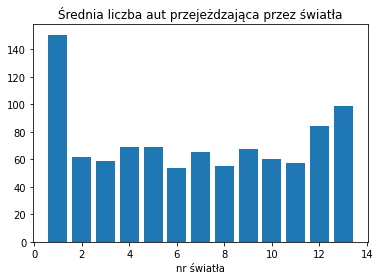

In [ ]:
plt.bar(range(1, 14), cars_on_lights)
plt.title("Średnia liczba aut przejeżdzająca przez światła")
plt.xlabel("nr światła")

W ciągu 100 symulacjii trwających każda 1000 kroków, przez pierwsze światła przejeżdza średnio o wiele więcej aut niż przez inne. Jest to związane za równo z tym, że jest to ulica wjazdowa oraz z tym, że $t_1$ sąsiaduje z najmniej zakorkowaną ulicą jednokierunkową.

Text(0.5, 0, 'nr skrzyżowania')

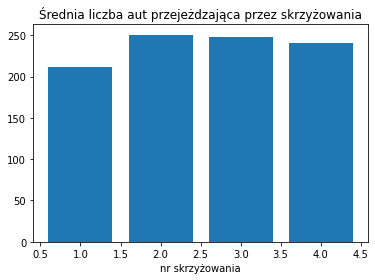

In [ ]:
plt.bar(range(1, 5), [sum(cars_on_lights[0:2]), sum(cars_on_lights[2:6]), sum(cars_on_lights[6:10]), sum(cars_on_lights[10:])])
plt.title("Średnia liczba aut przejeżdzająca przez skrzyżowania")
plt.xlabel("nr skrzyżowania")

W przypadku ilości aut przejeżdzających przez całe skrzyżowanie, wbrew oczekiwanią przez pierwsze skrzyżowanie przejeżdża najmniej samochodów. Na niewielkie prowadzenie wysuwa się skrzyżowanie numer 2.

**Ilość aut które oczekują na wjazd od czasu**

Na koniec przyjrzyjmy się ilości aut, które chcą wjechać do naszego miasta, ale nie mogą.

In [ ]:
def waiting_cars_in_time(T=1000, lambdas=None, tau_list=[5 for i in range(13)]):
    """Calculates number of cars waiting before each entrance in T steps. 
    If lambdas is gives, it changes the default intensities of car's appearance 
    to the gives (lambdas - list of 7 functions). Similarly, tau_list (list of 13 ints)
    enables to change the durations of green lights."""
    M = MotorTraffic(lambdas=lambdas)
    waiting_cars = np.zeros((7, T))
    if tau_list != [5 for i in range(13)]:
        for count, i in enumerate(tau_list):
            if i != 5:
                M.change_tau("t" + str(count + 1), i)
    for t in range(T):
        M.step()
        waiting_cars[:, t] = [len(M.waiting_cars[n]) for n in range(7)]
    return waiting_cars

def waiting_cars_in_time_mean(N=100, T=1000, lambdas=None, tau_list=[5 for i in range(13)]):
    """Calculates mean number of cars waiting before each entrance in T steps. 
    Takes mean on N MottorTraffic. If lambdas is gives, it changes the default 
    intensities of car's appearance to the gives (lambdas - list of 7 functions).
    Similarly, tau_list (list of 13 ints) enables to change the durations of green lights."""
    mean_array = waiting_cars_in_time(T, lambdas=lambdas, tau_list=tau_list)
    for i in range(N-1):
        mean_array += waiting_cars_in_time(T, lambdas=lambdas, tau_list=tau_list)
    return mean_array/N

In [ ]:
waiting_cars = waiting_cars_in_time_mean()

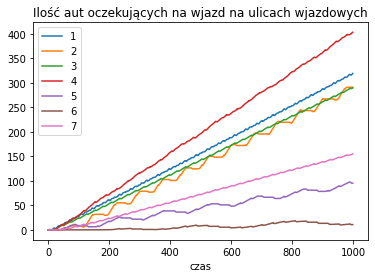

In [ ]:
for i in range(7):
    plt.plot(waiting_cars[i, :])
plt.title("Ilość aut oczekujących na wjazd na ulicach wjazdowych")
plt.xlabel("czas")
plt.legend(range(1,8))

Ilość aut przed niektórymi wjazdami rośnie bardzo szybko. Za największą ilość oczekujących aut odpowiada $\lambda_4$, po 1000 krokach kolejka składa się z ponad 400 pojazdów, a przypomnijmy, że pojemność naszego miasta to tylko 220 aut. Większość domyślnych intensywności jest więc zdecydowanie za duża, jak na możliwości naszych ulic. Tylko przed jednym wjazdem kolejka jest dosyć mała, jest to wjazd na ulice $n_{10}$.

Text(0.5, 0, 'czas')

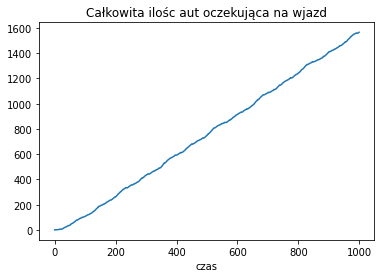

In [ ]:
plt.plot(np.sum(waiting_cars, axis=0))
plt.title("Całkowita ilośc aut oczekująca na wjazd")
plt.xlabel("czas")

Powyższy wykres przedstawia średnią ilość wszystkich oczekujących aut. Wykres bardzo szybko rośnie, co utwierdza nas w przekonaniu, że nasze miasto nie funkcjonuje zbyt dobrze.

## Drugi zestaw parametrów

Spróbujemy zmiejszyć korki w naszym mieście, wydłużając zielone światło dla najbardziej zakorkowanych ulic wjazdowych oraz dosyć drastycznie zmieniając rozkłady $\pi_j$ tak by auta szybciej zjeżdzały z mapy. Zmienimy też długość światła czerwonego dla pierwszych dwóch świateł na $\sigma_1 = \sigma_2 = 3$. Intensywności $\lambda_1, \dots, \lambda_7$ zostawimy domyśle.

In [ ]:
def change_lights_for_M(M):
    """Changes parameters of lights, returns MotorTraffic object. """
    M.change_lights("t1", 10, {(0, -1):2/100, (-1, 0):49/100, (0, 1):49/100}, 3)
    M.change_lights("t2", 5, {(0, 1):2/100, (-1, 0):49/100, (0, -1):49/100}, 3)
    M.change_lights("t3", 5, {(0, -1):49/100, (0, 1):1/100, (-1, 0):49/100, (1, 0):1/100}, 4)
    M.change_lights("t4", 10, {(0, -1):49/100, (0, 1):1/100, (-1, 0):49/100, (1, 0):1/100}, 4)
    M.change_lights("t5", 10, {(0, -1):49/100, (0, 1):1/100, (-1, 0):49/100, (1, 0):1/100}, 4)
    M.change_lights("t6", 5, {(0, -1):49/100, (0, 1):1/100, (-1, 0):49/100, (1, 0):1/100}, 4)
    M.change_lights("t7", 10, {(0, -1):49/100, (0, 1):49/100, (-1, 0):1/100, (1, 0):1/100}, 4)
    M.change_lights("t8", 5, {(0, -1):49/100, (0, 1):49/100, (-1, 0):1/100, (1, 0):1/100}, 4)
    M.change_lights("t9", 10, {(0, -1):49/100, (0, 1):49/100, (-1, 0):1/100, (1, 0):1/100}, 4)
    M.change_lights("t10", 5, {(0, -1):49/100, (0, 1):49/100, (-1, 0):1/100, (1, 0):1/100}, 4)
    M.change_lights("t11", 5, {(0, -1):49/100, (-1, 0):2/100, (1, 0):49/100}, 4)
    M.change_lights("t12", 10, {(0, -1):49/100, (-1, 0):2/100, (1, 0):49/100}, 4)
    M.change_lights("t13", 10, {(0, -1):49/100, (-1, 0):2/100, (1, 0):49/100}, 4)
    return M

**Średnia ilość samochodów na mapie od czasu**

In [ ]:
def mean_number_of_all_cars_2(N=100, T=1000):
    """Calculates mean number of cars on a map. Takes mean of N MottorTraffic objects.
    Returns list of means from begining to time T.
    """
    M = [change_lights_for_M(MotorTraffic()) for n in range(N)]
    count_cars = np.zeros(T)
    for t in range(T):
        for m in M:
            m.step()
            count_cars[t] += len(m.cars_on_road)
    return count_cars/N

In [ ]:
number_of_cars = mean_number_of_all_cars_2()

(0.0, 220.0)

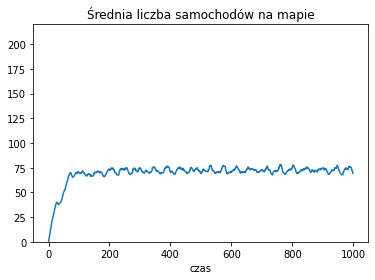

In [ ]:
plt.plot(number_of_cars)
plt.title("Średnia liczba samochodów na mapie")
plt.xlabel('czas')
plt.ylim(0, 220)

Całkowita ilość aut na mapie uległa mniejszeniu, z ok. 100 na 75. 

**Ilość aut na każdej ulicy od czasu**


In [ ]:
def cars_on_street_2(T=1000):
    """Calculates number of cars on each street in time from 0 to T. """
    M = MotorTraffic()
    M = change_lights_for_M(M)
    cars_streets = np.zeros((11, T))
    for t in range(T):
        M.step()
        a = M.map[9:11, 0:10] #n4
        cars_streets[3, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[22, 0:10] #n2
        cars_streets[1, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[0:9, 10:12] #n5
        cars_streets[4, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[0:9, 26:28] #n7
        cars_streets[6, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[0:9, 35:37] #n10
        cars_streets[9, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[9:11, 12:26] #n6
        cars_streets[5, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[9:11, 28:35] #n9
        cars_streets[8, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[9:11, 37:42] #n11
        cars_streets[10, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[11:22, 10:12] #n3
        cars_streets[2, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[23:29, 10:12] #n1
        cars_streets[0, t] = np.sum(np.where(a > 0, 1, 0))
        a = M.map[11:29, 26:28] #n8
        cars_streets[7, t] = np.sum(np.where(a > 0, 1, 0))
    return cars_streets

def mean_cars_on_street_2(T=1000, N=100):
    """Calculates mean number of cars on each street in time from 0 to T. 
    Takes mean of N MottosTraffics objects."""
    values = np.zeros((11, T))
    for n in range(N):
        values += cars_on_street_2(T)
    return values/N

In [ ]:
mean_cars_streets = mean_cars_on_street_2()

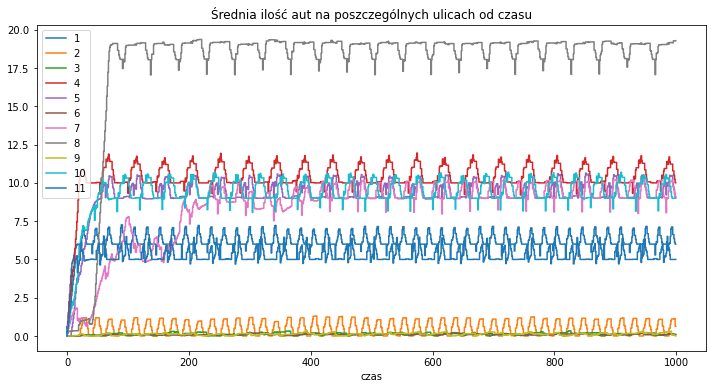

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(11):
    plt.step(range(1000), mean_cars_streets[i, :])
plt.title("Średnia ilość aut na poszczególnych ulicach od czasu")
plt.xlabel("czas")
plt.legend(range(1,12))

W przeciwieństie do poprzejniej analizy, ustabilizowały się wszystkie trajektorie. Poprzednio ulice niewjazdowe tego nie zrobiły, albo zrobiły to po dosyć długim czasie. Jeśli przyjrzymy się uważnie, zauważymy, że na ulicach łączących skrzyżowania nie ma w ogóle samochodów, jest to przyczyna naszych usilnych starań, aby auta szybciej wyjeżdzały z miasta. Zmieniły się też fluktuacje, ponieważ zmieniłyśmy czasy trwania zielonych świateł.

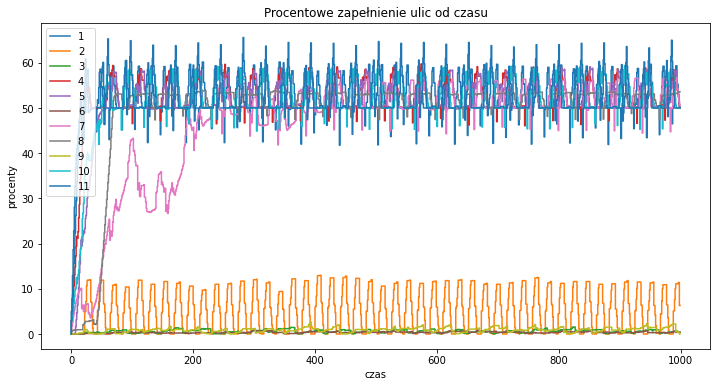

In [ ]:
streets_capacity = [12, 10, 22, 20, 18, 28, 18, 18*2, 14, 18, 10]
plt.figure(figsize=(12, 6))
for i in range(11):
    plt.step(range(1000), mean_cars_streets[i, :]/streets_capacity[i]*100)
plt.title("Procentowe zapełnienie ulic od czasu")
plt.ylabel("procenty")
plt.xlabel("czas")
plt.legend(range(1,12))

Wykres procentowego zapełnienia ulic pokazuje, że ulice wjazdowe nadal są zakorkowane, czyli nasze starania nie rozwiązały problemu.

**Średni czas oczkiwania na poszczególnych światłach**

In [ ]:
def mean_wait_on_lights_2(N=100, T=1000):
    """Calculates mean waiting times on each light during T steps. Takes mean 
    of N MottosTraffics objects."""
    waiting_times = np.zeros((N, 13))
    M = [change_lights_for_M(MotorTraffic()) for n in range(N)]
    for t in range(T):
        for m in M:
            m.step()
    for i, m in enumerate(M):
        waiting_times[i,:] = [m.waiting_times_lights[light][0]/m.waiting_times_lights[light][1] if m.waiting_times_lights[light][1] != 0 else 0 for light in m.waiting_times_lights]
    return np.sum(waiting_times, axis=0)/N

In [ ]:
wait_on_lights = mean_wait_on_lights_2()

Text(0.5, 0, 'nr światła')

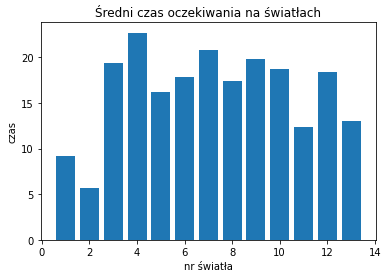

In [ ]:
plt.bar(range(1, 14), wait_on_lights)
plt.title("Średni czas oczekiwania na światłach")
plt.ylabel("czas")
plt.xlabel("nr światła")

Niestety czasy oczekiwania na światłach wzrostły, poza paroma przypadkami.

Text(0.5, 0, 'nr skrzyżowanie')

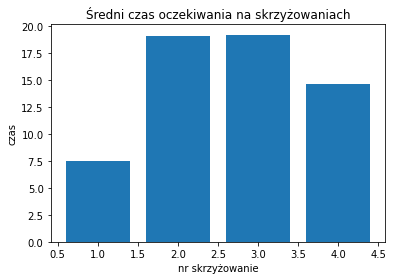

In [ ]:
plt.bar(range(1, 5), [sum(wait_on_lights[0:2])/2, sum(wait_on_lights[2:6])/4, sum(wait_on_lights[6:10])/4, sum(wait_on_lights[10:])/3])
plt.title("Średni czas oczekiwania na skrzyżowaniach")
plt.ylabel("czas")
plt.xlabel("nr skrzyżowanie")

Z kolei na całych skrzyżowaniach czasy te co do reguły wzrosły.

**Średnia ilość samochodów, które przejechały przez każde światło/skrzyżowanie**

In [ ]:
def mean_number_of_cars_on_lights_2(N=100, T=1000):
    """Calculates mean number of cars, which passed each light during T steps. Takes mean 
    of N MottosTraffics objects."""
    count_cars = np.zeros((N, 13))
    M = [change_lights_for_M(MotorTraffic()) for n in range(N)]
    for t in range(T):
        for m in M:
            m.step()
    for i, m in enumerate(M):
        count_cars[i,:] = [m.waiting_times_lights[light][1] for light in m.waiting_times_lights]
    return np.sum(count_cars, axis=0)/N

In [ ]:
cars_on_lights = mean_number_of_cars_on_lights_2()

Text(0.5, 0, 'nr światła')

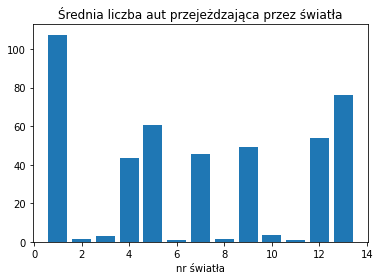

In [ ]:
plt.bar(range(1, 14), cars_on_lights)
plt.title("Średnia liczba aut przejeżdzająca przez światła")
plt.xlabel("nr światła")

Zmiana $\pi_j$ spowodowała, że na niektóre światła przyjeżdzało o wiele mniej aut niż poprzednio. Z kolei przez światła na ulicach wiazdowych przejechało tyle samo, a nawet mniej aut niż prędzej.

Text(0.5, 0, 'nr skrzyżowania')

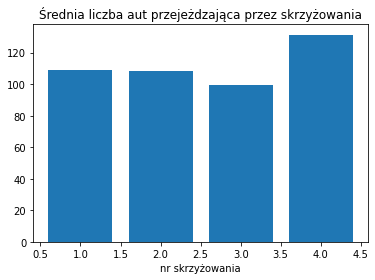

In [ ]:
plt.bar(range(1, 5), [sum(cars_on_lights[0:2]), sum(cars_on_lights[2:6]), sum(cars_on_lights[6:10]), sum(cars_on_lights[10:])])
plt.title("Średnia liczba aut przejeżdzająca przez skrzyżowania")
plt.xlabel("nr skrzyżowania")

Porównując powyższy wykres z tym dla poprzdnich parametrów, widzimy, że teraz przez skrzyżowania przejeżdza ok. 2 razy mniej samochodów. Zmienił się też kształt tego wykresu, tym razem na niewielkim prowadzeniu jest $S_4$.

**Ilość aut które oczekują na wjazd od czasu**

In [ ]:
def waiting_cars_in_time_2(T=1000):
    """Calculates number of cars waiting before each entrance in T steps."""
    M = MotorTraffic()
    M = change_lights_for_M(M)
    waiting_cars = np.zeros((7, T))
    for t in range(T):
        M.step()
        waiting_cars[:, t] = [len(M.waiting_cars[n]) for n in range(7)]
    return waiting_cars

def waiting_cars_in_time_mean_2(N=100, T=1000):
    """Calculates mean number of cars waiting before each entrance in T steps.
    Takes mean of N MottorTraffic."""
    mean_array = waiting_cars_in_time_2(T)
    for i in range(N-1):
        mean_array += waiting_cars_in_time_2(T)
    return mean_array/N

In [ ]:
waiting_cars = waiting_cars_in_time_mean_2()

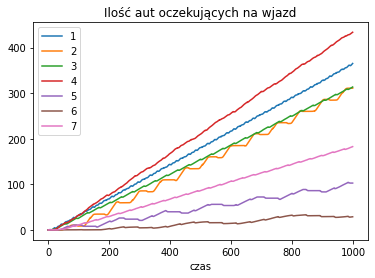

In [ ]:
for i in range(7):
    plt.plot(waiting_cars[i, :])
plt.title("Ilość aut oczekujących na wjazd")
plt.xlabel("czas")
plt.legend(range(1,8))

Na powyższym wykresie ostatecznie widać, że wydłużenie zielonego światła dla ulic wiazdowych i zmiana $\pi_j$ nie pomogły rozwiązać problemu zakorkowanego miasta.

Text(0.5, 0, 'czas')

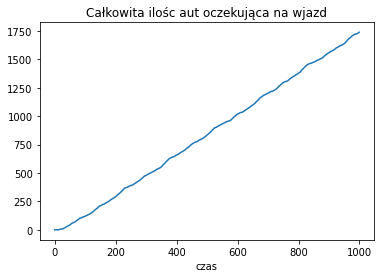

In [ ]:
plt.plot(np.sum(waiting_cars, axis=0))
plt.title("Całkowita ilośc aut oczekująca na wjazd")
plt.xlabel("czas")

Co ciekawe sumaryczna ilość oczekujących na wjazd pojazdów jest teraz nawet większa.

## Trzeci zestaw parametrów

Skoro zmiana parametrów świateł nie pomogła, to najwidoczniej trzeba zmienić intensywnosci $\lambda_1, \dots, \lambda_7$ na mniejsze.

In [ ]:
def fun_1(x):
    return 1/5*(0.8 + 0.8*np.sin(x/2))

def fun_2(x):
    return 1/5*((np.exp(6/5*np.sin(x/12 + 3) - 0.9))**3)

def _fun_3(x):
    return 1/5*(1/2)

fun_3 = np.vectorize(_fun_3)

def fun_4(x):
    return 1/8*(0.7 + 0.6 * np.sin(x/7 + 2)**2*np.cos(x/3 + 1))

def fun_5(x):
    return 1/5*(0.2 + 0.2 * np.sign(np.sin(x/24 + 6)))

def fun_6(x):
    return 1/5*(0.1 + 0.1 * np.sin(np.sqrt(x)))

def fun_7(x):
    return 1/5*(0.3 + 0.3 * np.sin(4*np.sin(x/2)))

lambdas = [fun_1, fun_2, fun_3, fun_4, fun_5, fun_6, fun_7]

**Średnia ilość samochodów na mapie od czasu**

In [ ]:
number_of_cars = mean_number_of_all_cars(lambdas=lambdas)

(0.0, 220.0)

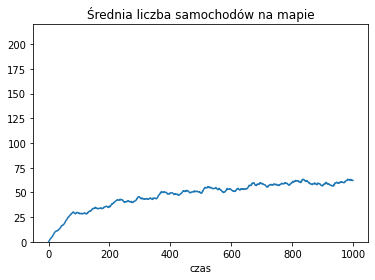

In [ ]:
plt.plot(number_of_cars)
plt.title("Średnia liczba samochodów na mapie")
plt.xlabel('czas')
plt.ylim(0, 220)

Dla tak dobranych intensywności jest mniej aut w naszym mieście. Tylko ok. $20 \%$ miejsca na drodze jest zajęte.

**Ilość aut na każdej ulicy od czasu**


In [ ]:
mean_cars_streets = mean_cars_on_street(lambdas=lambdas)

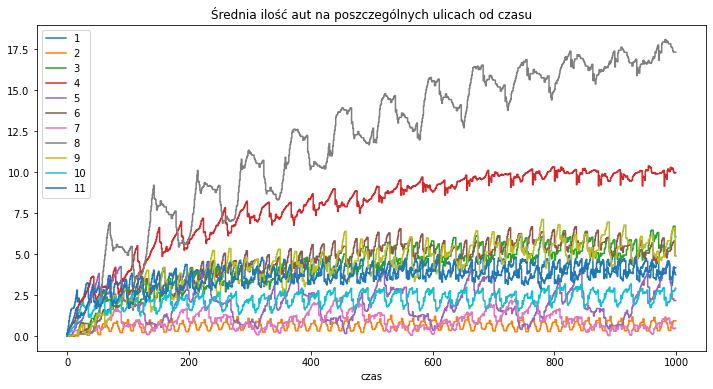

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(11):
    plt.step(range(1000), mean_cars_streets[i, :])
plt.title("Średnia ilość aut na poszczególnych ulicach od czasu")
plt.xlabel("czas")
plt.legend(range(1,12))

W porównaniu z wyjściowymi parametrami ilość aut na ulicach zmalała.

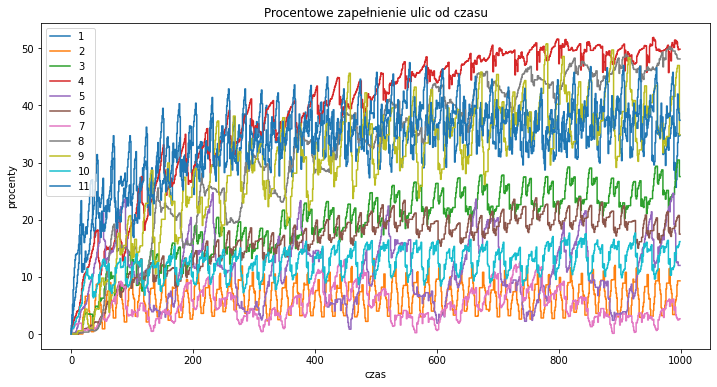

In [ ]:
streets_capacity = [12, 10, 22, 20, 18, 28, 18, 18*2, 14, 18, 10]
plt.figure(figsize=(12, 6))
for i in range(11):
    plt.step(range(1000), mean_cars_streets[i, :]/streets_capacity[i]*100)
plt.title("Procentowe zapełnienie ulic od czasu")
plt.ylabel("procenty")
plt.xlabel("czas")
plt.legend(range(1,12))

Na powyższym wykresie wydać, jaki procent danej ulicy jest zajęty przez samochody. Zapełnienie jest oczywiście mniejsze. Kilka ulic nadal się korkuje, ale przynajmniej nie w kilku początkowych krokach symulacjii. Możemy też dostrzec, że fluktuacje zrobiły się większe.

**Średni czas oczkiwania na poszczególnych światłach**

In [ ]:
wait_on_lights = mean_wait_on_lights(lambdas=lambdas)

Text(0.5, 0, 'nr światła')

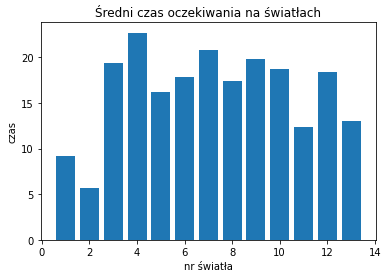

In [ ]:
plt.bar(range(1, 14), wait_on_lights)
plt.title("Średni czas oczekiwania na światłach")
plt.ylabel("czas")
plt.xlabel("nr światła")

Czas oczekiwania na większości świateł zmalał, ale nie dużo. Nie widać znaczniej różnicy w porównaniu z początkowym stanem.

Text(0.5, 0, 'nr skrzyżowanie')

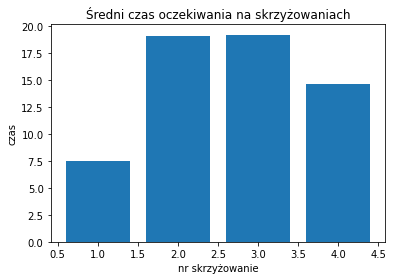

In [ ]:
plt.bar(range(1, 5), [sum(wait_on_lights[0:2])/2, sum(wait_on_lights[2:6])/4, sum(wait_on_lights[6:10])/4, sum(wait_on_lights[10:])/3])
plt.title("Średni czas oczekiwania na skrzyżowaniach")
plt.ylabel("czas")
plt.xlabel("nr skrzyżowanie")

Również ten wykres jest niemal identyczny.

**Średnia ilość samochodów, które przejechały przez każde światło/skrzyżowanie**

In [ ]:
cars_on_lights = mean_number_of_cars_on_lights(lambdas=lambdas)

Text(0.5, 0, 'nr światła')

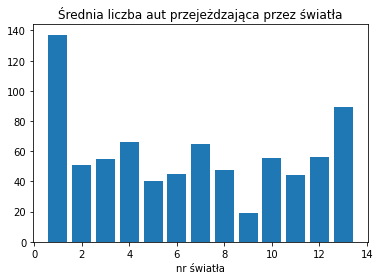

In [ ]:
plt.bar(range(1, 14), cars_on_lights)
plt.title("Średnia liczba aut przejeżdzająca przez światła")
plt.xlabel("nr światła")

Z kolei średnia ilość aut przejeżdzających przez skrzyżowania zmalała, co współgra z mniejszą ilością aut na drogach.

Text(0.5, 0, 'nr skrzyżowania')

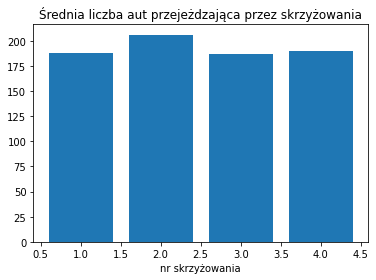

In [ ]:
plt.bar(range(1, 5), [sum(cars_on_lights[0:2]), sum(cars_on_lights[2:6]), sum(cars_on_lights[6:10]), sum(cars_on_lights[10:])])
plt.title("Średnia liczba aut przejeżdzająca przez skrzyżowania")
plt.xlabel("nr skrzyżowania")

Oczywiście liczba pojazdów przejeżdzających przez skrzyżownia również musiała zmaleć.

**Ilość aut które oczekują na wjazd od czasu**

In [ ]:
waiting_cars = waiting_cars_in_time_mean(lambdas=lambdas)

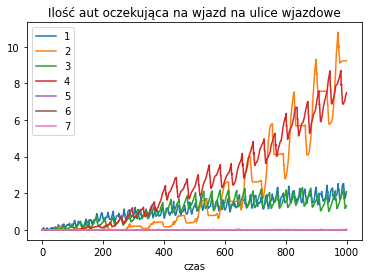

In [ ]:
for i in range(7):
    plt.plot(waiting_cars[i, :])
plt.title("Ilość aut oczekująca na wjazd na ulice wjazdowe")
plt.xlabel("czas")
plt.legend(range(1,8))

Największą zmianę obserwujemy w ilości aut oczekujących na wjazd do miasta. Ilości te są o wiele mniejsze i nie tak przerażające jak te początkowe.

Text(0.5, 0, 'czas')

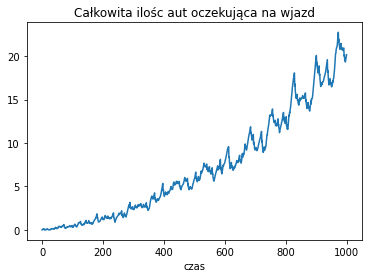

In [ ]:
plt.plot(np.sum(waiting_cars, axis=0))
plt.title("Całkowita ilośc aut oczekująca na wjazd")
plt.xlabel("czas")

Liczba wszystkich oczekujących na wjazd aut zmalała z ok. 1600 do ponad 20. Więc pomimo iż ulice wiazdowe nadal się korkują, sytuacja jest o wiele lepsza niż w pierwszej analizie.

# Podsumowanie analiz

Potraktowałyśmy te analizy jako próbe znalezienia rozwiązania dla korkującego się miasta. Początkowo chciałyśmy rozkorkować miasto zmieniając tylko parametry świateł, niestety bez skutku. Postanowiłyśmy więc zmienić też rozkłady wyboru kierunków na skrzyżowaniach, co również nie dało oczekiwanych rezultatów. Tak więc albo nie umiemy dobierać parametrów i rozkładów, albo przy domyślnych intensywnościach miasto zawsze będzie się korkować. Założyłyśmy oczywiście to drugie i sprawdziłyśmy jak zachowa się nasza symulacja dla rzadziej pojawiających się samochodów. Okazało się, że nadal nie rozwiązuje to całkowicie problemu korków, ale na pewno go ogranicza. Reasumując jedyne rozwiązanie problemu zakorkowanego miasta jakie przychodzi nam do głowy to ograniczenie samochodów na ulicach.

# GUI

Poniżej znajduje się jupyterowe GUI pozwalające obserwować ruch samochodowy w naszym hipotetycznym mieście. Możemy określić czas trawania symulacji, zapisać ją jako gif oraz modyfikować parametry świateł.

In [9]:
def init_layout():
    def on_button_clicked(b):
        output = widgets.Output()
        tau_list = [i.value for i in tau_slider_list]
        M = MotorTraffic()
        if [5 for i in range(len(tau_list))] != tau_list:
                for count, i in enumerate(tau_list):
                    5 != tau_list[count]
                    M.change_tau("t" + str(count + 1),tau_list[count])
        if if_display.value and save_anim.value:
            display(output)
            fps = 30
            nSeconds = T_input.value
            fig = plt.figure( figsize=(8,8) )
            a = M.map
            cmap = colors.ListedColormap(['yellowgreen','grey','turquoise','teal','cornflowerblue', 'indigo', 'cadetblue', 'slateblue', 'hotpink'])
            im = plt.imshow(a, interpolation='none', vmin=-1, vmax=7, cmap = cmap)
            def animate_func(i):
                if i % fps == 0:
                    print( '.', end ='' )
                M.step()
                with output:
                    im = plt.imshow(M.map, interpolation='none', vmin=-1, vmax=7, cmap = cmap)
                    display(plt.gcf())
                    clear_output(wait=True)
                im.set_array(M.map)
                return [im]

            anim = animation.FuncAnimation(
                                           fig, 
                                           animate_func, 
                                           frames = nSeconds * fps,
                                           interval = 1000 / fps, # in ms
                                           )
            anim.save("animacja.mp4", fps=fps, writer='ffmpeg')
            
        elif if_display.value:
            clear_output()
            display(output)
            cmap = colors.ListedColormap(['yellowgreen','grey','turquoise','teal','cornflowerblue', 'indigo', 'cadetblue', 'slateblue', 'hotpink'])
            for i in range(30*T_input.value):
                with output:
                    M.step()
                    plt.imshow(M.map, interpolation='none', vmin=-1, vmax=7, cmap = cmap)
                    display(plt.gcf())
                    clear_output(wait=True)
                
        elif save_anim.value:
            fps = 10
            nSeconds = T_input.value
            fig = plt.figure( figsize=(8,8) )
            a = M.map
            cmap = colors.ListedColormap(['yellowgreen','grey','turquoise','teal','cornflowerblue', 'indigo', 'cadetblue', 'slateblue', 'hotpink'])
            im = plt.imshow(a, interpolation='none', vmin=-1, vmax=7, cmap = cmap)
            def animate_func(i):
                if i % fps == 0:
                    print( '.', end ='' )
                M.step()
                im.set_array(M.map)
                return [im]

            anim = animation.FuncAnimation(
                                           fig, 
                                           animate_func, 
                                           frames = nSeconds * fps,
                                           interval = 1000 / fps, # in ms
                                           )
            anim.save("animacja.mp4", fps=fps, writer='ffmpeg')
            
        on_reset()

    def on_reset():
        clear_output(wait = False)
        init_layout()

    def make_tau_slider():
        global tau_slider_list
        tau_slider_list = []
        for i in range(1, 14):
            tau_slider_list.append(widgets.IntSlider(
                    value=5,
                    min=1,
                    max=15,
                    description= 't'+str(i),
                    disabled=False,
                    continuous_update=False,
                    orientation='vertical',
                    readout=True,
                    readout_format='.1f',
                ))
        global tau_HBox
        tau_HBox = HBox(tau_slider_list)
        display(tau_HBox)
        
    make_tau_slider()

    save_anim = widgets.Checkbox(
        value=False,
        description='Save animation',
        disabled=False,
        indent=False
    )

    if_display = widgets.Checkbox(
        value=False,
        description='Display animation',
        disabled=False,
        indent=False
    )
    
    T_input =  widgets.BoundedIntText(
        value=5,
        min=1,
        max=100,
        step=1,
        description='Animation time:',
        disabled=False,
        style = {'description_width': 'initial'}
    )
    anim_button = widgets.Button(
        value=False,
        description='Make animation',
        disabled=False,
        button_style='',
        tooltip='Description',
        icon=''
    )

    reset_button = widgets.Button(
        value=False,
        description='Reset',
        disabled=False,
        button_style='',
        tooltip='Description',
        icon=''
    )

    
    display(T_input)
    display(save_anim)
    display(if_display)
    display(anim_button)
    
    anim_button.on_click(on_button_clicked)

init_layout()

Output()